# Predicting Box Office Revenue

* Author: Jay Huang
* E-mail: askjayhuang at gmail dot com
* GitHub: https://github.com/jayhuang1
* Created: 2018-01-17

This workshop predicts box office revenue of a movie using the TMDB 5000 dataset (https://www.kaggle.com/tmdb/tmdb-movie-metadata/data). A regression algorithm will be used to predict revenue based on variables such as budget, genre, popularity, and runtime.

## Data Ingestion

Two csv files are downloaded from Kaggle into a data directory and imported into DataFrames:

In [1]:
import pandas as pd

MOVIES_PATH = 'data/tmdb_5000_movies.csv'
CREDITS_PATH = 'data/tmdb_5000_credits.csv'

df_movies = pd.read_csv(MOVIES_PATH)
df_credits = pd.read_csv(CREDITS_PATH)
df_merged = pd.merge(df_movies, df_credits, left_on='id', right_on='movie_id')

## Data Wrangling

Let's prepare the dataset for machine learning by dropping instances with missing revenue, converting string values into a list of data we want to use, and dropping any variables that aren't relevant to our regression problem:  

In [2]:
def wrangle_df(df):
    """Wrangle movies DataFrame."""
    # Drop columns
    df.drop(['title_x', 'title_y', 'id', 'movie_id', 'homepage', 'original_language', 'overview', 'production_countries', 'spoken_languages', 'status', 'tagline', 'release_date'], axis=1, inplace=True)

    # Drop row with missing revenue data
    df = df[df.revenue != 0]

    # Convert strings into list of wanted values
    df.cast = [eval(x) for x in df.cast]
    for idx, movie in df.cast.iteritems():
        cast = []
        for character in movie:
            cast.append(character['name'])
        df.cast.set_value(idx, cast)

    df.crew = [eval(x) for x in df.crew]
    directors_all = []
    writers_all = []
    for idx, movie in df.crew.iteritems():
        directors = []
        writers = []
        for crew in movie:
            if crew['job'] == 'Director':
                directors.append(crew['name'])
            if crew['department'] == 'Writing':
                writers.append(crew['name'])
        directors_all.append(list(set(directors)))
        writers_all.append(list(set(writers)))
    df = df.assign(directors=directors_all, writers=writers_all)
    # df['directors'] = directors_all
    # df['writers'] = writers_all
    df.drop('crew', axis=1, inplace=True)

    df.genres = [eval(x) for x in df.genres]
    for idx, movie in df.genres.iteritems():
        genres = []
        for genre in movie:
            genres.append(genre['name'])
        df.genres.set_value(idx, genres)

    df.keywords = [eval(x) for x in df.keywords]
    for idx, movie in df.keywords.iteritems():
        keywords = []
        for keyword in movie:
            keywords.append(keyword['name'])
        df.keywords.set_value(idx, keywords)

    df.production_companies = [eval(x) for x in df.production_companies]
    for idx, movie in df.production_companies.iteritems():
        companies = []
        for company in movie:
            companies.append(company['name'])
        df.production_companies.set_value(idx, companies)

    # Re-arrange index and columns
    df = df.reindex(columns=['original_title', 'runtime', 'genres', 'keywords', 'production_companies',
                             'cast', 'directors', 'writers', 'vote_average', 'vote_count', 'popularity', 'budget', 'revenue'])
    df.set_index('original_title', drop=True, inplace=True)

    df.drop(['keywords', 'production_companies', 'cast', 'directors', 'writers'], axis=1, inplace=True)

    return df

In [3]:
df = wrangle_df(df_merged)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## Data Exploration

Let's print out the first few rows of our wrangle data:

In [9]:
df.head()

,runtime,genres,vote_average,vote_count,popularity,budget,revenue
original_title,,,,,,,
Avatar,162.0,"[Action, Adventure, Fantasy, Science Fiction]",7.2,11800,150.437577,237000000,2787965087
Pirates of the Caribbean: At World's End,169.0,"[Adventure, Fantasy, Action]",6.9,4500,139.082615,300000000,961000000
Spectre,148.0,"[Action, Adventure, Crime]",6.3,4466,107.376788,245000000,880674609
The Dark Knight Rises,165.0,"[Action, Crime, Drama, Thriller]",7.6,9106,112.312950,250000000,1084939099
John Carter,132.0,"[Action, Adventure, Science Fiction]",6.1,2124,43.926995,260000000,284139100


Let's then explore the frequency of genres and the budget/revenue distribution:

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from itertools import chain

def explore_data(df):
    """Explore frequency values of data."""
    genres = list(chain.from_iterable(df.genres))

    print('Number of Genres:', len(set(genres)))

    sns.set()
    ax = sns.countplot(y=genres)
    plt.ylabel('Genre')
    plt.title('Genre Frequency')
    plt.show()

    formatter = FuncFormatter(millions_format)
    ax = sns.distplot(df.budget, kde=False)
    ax.xaxis.set_major_formatter(formatter)
    plt.title('Budget Distribution')
    plt.show()

    ax = sns.distplot(df.revenue, kde=False)
    ax.xaxis.set_major_formatter(formatter)
    plt.title('Revenue Distribution')
    plt.show()
    
def millions_format(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x * 1e-6)

Number of Genres: 19


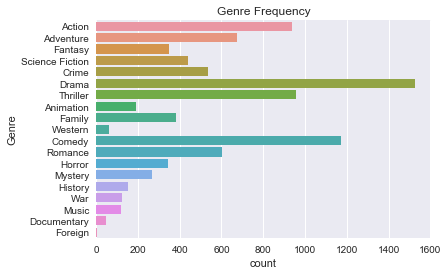

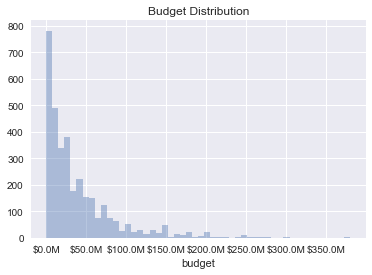

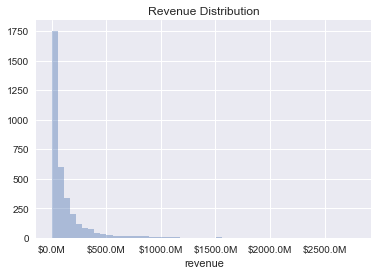

In [8]:
explore_data(df)

As we can see, the most common genres are drama, comedy, and thriller. Budget and revenue appear to have a similar distribution skewed to the left. Let's keep this in mind for when we determine the relationship between budget and revenue after we fit our regression model.

## Model Building

Since machine learning models don't take a list of values as inputs, we have to one hot encode the list of genres into a plurality of columns:

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression

def multi_label_binarize(data):
    mlb = MultiLabelBinarizer()

    for feature in categorical_features:
        data[feature] = mlb.fit_transform(data[feature]).tolist()
        features = list(mlb.classes_)
        data[features] = pd.DataFrame(data[feature].values.tolist(), index=data.index)
        data.drop(feature, axis=1, inplace=True)

    return data

In [11]:
# Set X and y
X = df.drop('revenue', axis=1)
y = df.revenue

# Find categorical features in DataFrame
categorical_features = [column for column in X.columns if X[column].dtype == 'object']

# Binarize categorical features
X = multi_label_binarize(X)

Let's take a look at the data after the one hot encoding:

In [12]:
X.head()

,runtime,vote_average,vote_count,popularity,budget,Action,Adventure,Animation,Comedy,Crime,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
original_title,,,,,,,,,,,,,,,,,,,,,
Avatar,162.0,7.2,11800,150.437577,237000000,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Pirates of the Caribbean: At World's End,169.0,6.9,4500,139.082615,300000000,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Spectre,148.0,6.3,4466,107.376788,245000000,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
The Dark Knight Rises,165.0,7.6,9106,112.312950,250000000,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
John Carter,132.0,6.1,2124,43.926995,260000000,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Let's then run a simple linear regression on all of the data to determine the coefficients of the variables used to predict revenue:

In [13]:
# Fit data into linear regression model
regr = LinearRegression()
regr.fit(X, y)

# Format coefficients into human readable data
fl = ["${:,.2f}".format(x) for x in list(regr.coef_)]

for feature, coef in zip(X.columns, fl):
    print(feature, coef)

runtime $470,921.21
vote_average $-1,860,610.79
vote_count $66,617.90
popularity $240,801.46
budget $1.57
Action $-6,659,973.49
Adventure $20,773,539.84
Animation $30,438,896.44
Comedy $4,930,764.74
Crime $-16,414,526.90
Documentary $20,118,814.14
Drama $-14,252,781.60
Family $24,746,797.60
Fantasy $-1,908,431.77
Foreign $-6,164,060.08
History $-15,222,491.29
Horror $10,248,146.84
Music $10,452,033.17
Mystery $-9,774,930.85
Romance $16,600,808.97
Science Fiction $-32,615,689.87
Thriller $-2,325,417.39
War $-15,894,819.24
Western $-39,354,049.73


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


## Model Evaluation

Let's then split the data into training and test data to test the accuracy of our model:

In [15]:
# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

regr = LinearRegression()

regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Let's then predict revenue using the test data:

In [17]:
y_pred = regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 14394887629038392.00
Variance score: 0.69


## Conclusion

As we can see, our model has a variance score of 0.69